In [1]:
# !pip install -q pytorchvideo evaluate

In [2]:
# pip install -q pyarrow==14.0.1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.6.1 requires cubinlinker, which is not installed.
cudf 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.6.1 requires ptxcompiler, which is not installed.
cuml 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.6.1 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 14.0.1 which is incompatible.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.2.3 which is incompatible.
cudf 24.6.1 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.5.0 which

In [3]:
# pip install -q transformers --upgrade

Note: you may need to restart the kernel to use updated packages.


> # **Data Collection and Aggregation**

In [1]:
import os
import pandas as pd

root_path = "/kaggle/input/nepali-sign-languagee"
folder_list = os.listdir(root_path)
label_list = [path for path in folder_list if not path.endswith((".csv"))]

total_df = pd.read_csv(os.path.join(root_path,"train.csv"))

total_df.reset_index(drop = True, inplace = True)
total_df['label'].value_counts()

label
ma_ghar_ma_dherei_kam_garchu         16
ma_snga_dherei_paisa_chhaina         12
mero_sathi_haru_bhaktapur_ma_chan    12
mero_dherei_sathi_haru_chhan          8
mero_ghar_bhaktapur_ma_cha            8
Name: count, dtype: int64

> # **Data Splitting**

In [2]:
from sklearn.model_selection import train_test_split

def correct_file_path(file_name: str, root_path: str):
    return os.path.join(root_path, file_name)

def preprocess_meta_df(df, root_path, label2id):
    df.rename(columns={"video_name": "video_path"}, inplace=True)
    df['video_path'] = df['video_path'].apply(lambda x: correct_file_path(x, root_path))
    df['label'] = df['label'].apply(lambda x: label2id[x])
    return df

train_meta_df, test_meta_df = train_test_split(total_df, test_size=0.2, stratify=total_df['label'], random_state=42)

label_list = list(set(train_meta_df['label']))
class_labels = sorted(label_list)
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

train_meta_df = preprocess_meta_df(train_meta_df, root_path, label2id)
test_meta_df = preprocess_meta_df(test_meta_df, root_path, label2id)

print("Splitted data:", len(train_meta_df), len(test_meta_df))

Unique classes: ['ma_ghar_ma_dherei_kam_garchu', 'ma_snga_dherei_paisa_chhaina', 'mero_dherei_sathi_haru_chhan', 'mero_ghar_bhaktapur_ma_cha', 'mero_sathi_haru_bhaktapur_ma_chan'].
Splitted data: 44 12


> #  **Model Selection and Design**

In [4]:
# pip install -q torch==2.0.1 torchvision==0.15.2 --extra-index-url https://download.pytorch.org/whl/cu118 xformers==0.0.21

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import pytorchvideo.data
from torch.utils.data import Dataset
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
from transformers import VivitImageProcessor, VivitModel, VivitForVideoClassification

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

model_checkpoint = "google/vivit-b-16x2-kinetics400"
image_processor = VivitImageProcessor.from_pretrained(model_checkpoint)
# model = VivitForVideoClassification.from_pretrained(model_checkpoint, label2id=label2id, id2label=id2label, ignore_mismatched_sizes=True)
model = VivitForVideoClassification.from_pretrained(model_checkpoint)
# model=VivitModel.from_pretrained(model_checkpoint)

2024-08-19 03:30:29.501361: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 03:30:29.501503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 03:30:29.632958: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/356M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


## Original Model

In [4]:
model

VivitForVideoClassification(
  (vivit): VivitModel(
    (embeddings): VivitEmbeddings(
      (patch_embeddings): VivitTubeletEmbeddings(
        (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): VivitEncoder(
      (layer): ModuleList(
        (0-11): 12 x VivitLayer(
          (attention): VivitAttention(
            (attention): VivitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): VivitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): VivitIntermediate(
           

## Don't Need the Final Classifier Layer

In [5]:
#Replace final classifier layer with the identity function, it just returns what it gets

class Identity(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x
    
model.classifier=Identity()
model

VivitForVideoClassification(
  (vivit): VivitModel(
    (embeddings): VivitEmbeddings(
      (patch_embeddings): VivitTubeletEmbeddings(
        (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): VivitEncoder(
      (layer): ModuleList(
        (0-11): 12 x VivitLayer(
          (attention): VivitAttention(
            (attention): VivitSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): VivitSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): VivitIntermediate(
           

> # **Data Preprocessing and Cleaning**

In [6]:
class CustomVideoDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        video_path = row['video_path']
        label = row['label']
        return video_path, label

mean = image_processor.image_mean
std = image_processor.image_std

if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]

resize_to = (model.config.image_size, model.config.image_size)

# num_frames_to_sample = model.config.num_frames
num_frames_to_sample = 32
clip_duration = 8

train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    Resize(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

train_custom_dataset = CustomVideoDataset(train_meta_df)
train_labeled_video_paths = [(video_path, {'label': label}) for video_path, label in train_custom_dataset]

test_custom_dataset = CustomVideoDataset(test_meta_df)
test_labeled_video_paths = [(video_path, {'label': label}) for video_path, label in test_custom_dataset]

> # **Data Loading**

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


mero_ghar_bhaktapur_ma_cha


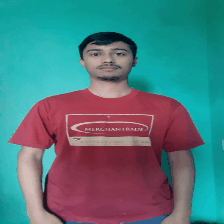

In [7]:
import imageio
import numpy as np
from IPython.display import Image

train_dataset = pytorchvideo.data.LabeledVideoDataset(
    labeled_video_paths =train_labeled_video_paths,
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

test_dataset = pytorchvideo.data.LabeledVideoDataset(
    labeled_video_paths =test_labeled_video_paths,
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

def unnormalize_img(img):
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 5}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

sample_video = next(iter(train_dataset))
video_tensor = sample_video["video"]
print(id2label[sample_video['label']])
display_gif(video_tensor)

In [ ]:
# infer_dataset = pytorchvideo.data.LabeledVideoDataset(
#     labeled_video_paths = [('/kaggle/input/inferencee/slomo1.avi',{'label':3})],
#     clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
#     decode_audio=False,
#     transform=val_transform,
# )

In [ ]:
# for video in infer_dataset:
#     print(video['video'].shape)
#     break

In [8]:
for frame in train_dataset:
    print(frame['video'].permute(1,0,2,3)[1,:,:,:].shape)
    break


torch.Size([3, 224, 224])


ma_snga_dherei_paisa_chhaina


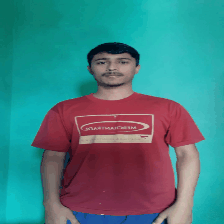

In [9]:
video_tensor = frame['video']
print(id2label[frame['label']])
display_gif(video_tensor)

In [ ]:
# out=model(frame['video'])

> # **Model and Data Preparation**

In [ ]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(7, 7, figsize=(12, 12))

# Plot images
f=0
for i in range(7):
    for j in range(7):
        f+=1
        if f<36:
          im=frame['video'].permute(1,0,2,3)[f,:,:,:].squeeze(0).permute(1,2,0)
          axs[i, j].imshow(im)
        axs[i, j].set_title(f'frame: {f}')
        axs[i, j].axis('off')  # Hide axis

plt.tight_layout()
plt.show()

In [ ]:
from transformers import TrainingArguments, Trainer

model_name = model_checkpoint.split("/")[-1]
new_model_name = f"{model_name}-nepali_sign_lang"
num_epochs = 2
batch_size = 1

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-6,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    torch_empty_cache_steps = 5,
    report_to='none',
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

In [ ]:
q=torch.randn(32,3,224,224)
l=[]
l.append(q)
l.append(q)

lab=torch.stack([i for i in l])
lab.shape

> # **Model Training and Validation**

In [ ]:
import evaluate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
recall_metric = evaluate.load("recall")
precision_metric = evaluate.load("precision")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=eval_pred.label_ids)
    f1 = f1_metric.compute(predictions=predictions, references=eval_pred.label_ids, average='weighted')
    recall = recall_metric.compute(predictions=predictions, references=eval_pred.label_ids, average='weighted')
    precision = precision_metric.compute(predictions=predictions, references=eval_pred.label_ids, average='weighted')
    combined_metrics = {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"],
        "recall": recall["recall"],
        "precision": precision["precision"]
    }
    return combined_metrics


def collate_fn(examples):
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

train_results = trainer.train()

In [ ]:
trained_model = VivitForVideoClassification.from_pretrained('/kaggle/working/vivit-b-16x2-kinetics400-nepali_sign_lang/checkpoint-88')

In [ ]:
sample_test_video = next(iter(test_dataset))

In [ ]:
sample_test_video['video'].shape

In [ ]:
sample_test_video['label']

In [10]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.

    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
#         "labels": torch.tensor(
#             [sample_test_video["label"]]
#         ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
#         logits = outputs.logits
    return outputs

#     return logits

In [12]:
# logits = run_inference(trained_model, sample_test_video["video"])
logits = run_inference(model, frame['video'])
print(logits.logits.shape)

torch.Size([1, 768])


In [ ]:
display_gif(sample_test_video["video"])


In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

predicted_class_idx